Backpropagation Neural Network Vs Multilayer Perceptron in Digit dataset

Training BPNN...
[BPNN] Epoch 1/60 - Train Loss: 2.1628 - Val Loss: 2.2188
[BPNN] Epoch 10/60 - Train Loss: 0.9834 - Val Loss: 1.0682
[BPNN] Epoch 20/60 - Train Loss: 0.5889 - Val Loss: 0.6917
[BPNN] Epoch 30/60 - Train Loss: 0.4145 - Val Loss: 0.5227
[BPNN] Epoch 40/60 - Train Loss: 0.3191 - Val Loss: 0.4273
[BPNN] Epoch 50/60 - Train Loss: 0.2597 - Val Loss: 0.3655
[BPNN] Epoch 60/60 - Train Loss: 0.2190 - Val Loss: 0.3224

Training sklearn MLP...
[MLP] Epoch 1/60 - Train Loss: 2.4799 - Val Loss: 2.2571
[MLP] Epoch 10/60 - Train Loss: 0.3398 - Val Loss: 0.4504
[MLP] Epoch 20/60 - Train Loss: 0.1698 - Val Loss: 0.2946
[MLP] Epoch 30/60 - Train Loss: 0.1162 - Val Loss: 0.2438
[MLP] Epoch 40/60 - Train Loss: 0.0876 - Val Loss: 0.2155
[MLP] Epoch 50/60 - Train Loss: 0.0696 - Val Loss: 0.1995
[MLP] Epoch 60/60 - Train Loss: 0.0573 - Val Loss: 0.1899

--- Test Results ---
BPNN Test Accuracy: 93.33% (Time: 0.18s)
MLP  Test Accuracy: 96.94% (Time: 0.34s)

BPNN Confusion Matrix:
 [[34  0  1  

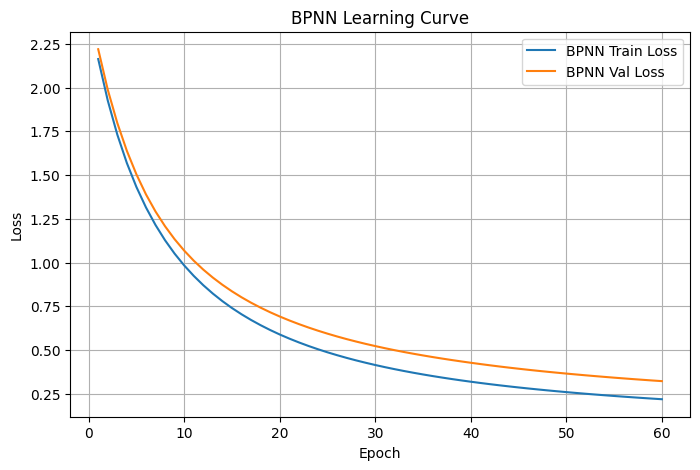

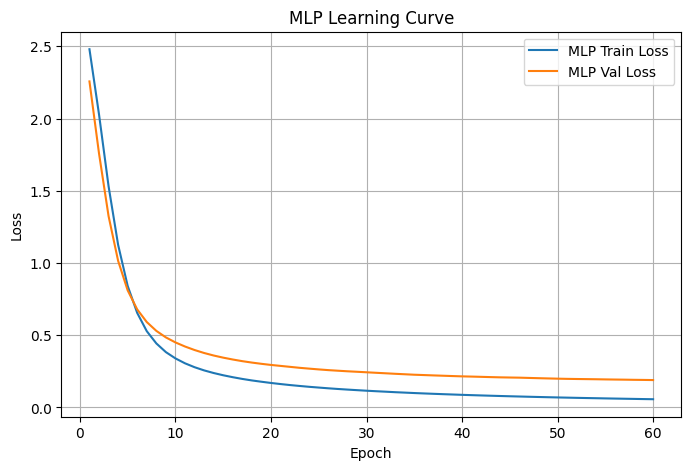

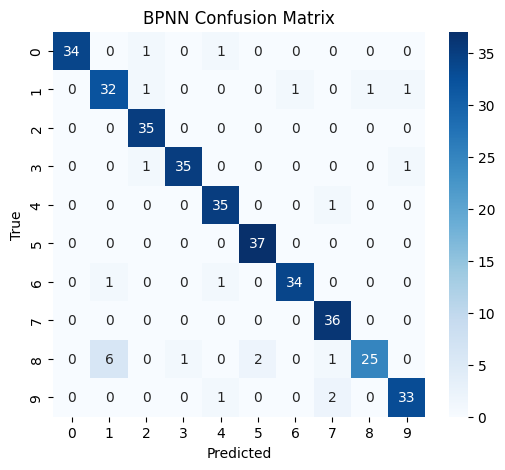

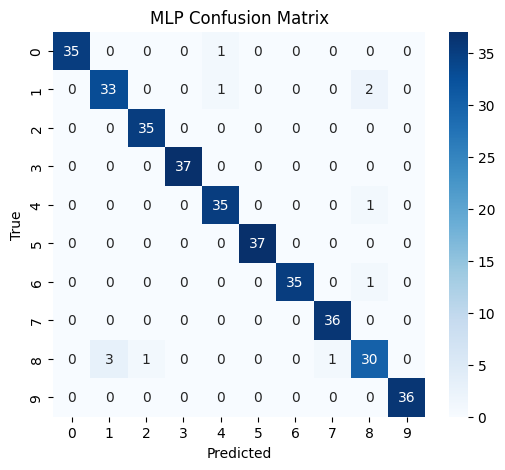

In [ ]:
import time
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

# Prepare dataset 
digits = load_digits()
X = digits.data  
y = digits.target 

# Split into train / val / test 
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

# One-hot BPNN
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1))
y_val_ohe = ohe.transform(y_val.reshape(-1,1))

# BPNN
class BPNN:
    def __init__(self, n_input, n_hidden, n_output, lr=0.01, seed=1):
        rng = np.random.RandomState(seed)
        # Xavier initialization
        self.W1 = rng.normal(0, np.sqrt(2.0/(n_input+n_hidden)), (n_input, n_hidden))
        self.b1 = np.zeros((1, n_hidden))
        self.W2 = rng.normal(0, np.sqrt(2.0/(n_hidden+n_output)), (n_hidden, n_output))
        self.b2 = np.zeros((1, n_output))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        e = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e / np.sum(e, axis=1, keepdims=True)

    def forward(self, X):
        Z1 = X.dot(self.W1) + self.b1
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.W2) + self.b2
        A2 = self.softmax(Z2)
        cache = (X, Z1, A1, Z2, A2)
        return A2, cache

    def compute_loss(self, Y_pred, Y_true_ohe):
        eps = 1e-12
        clipped = np.clip(Y_pred, eps, 1.0 - eps)
        return -np.mean(np.sum(Y_true_ohe * np.log(clipped), axis=1))

    def backward(self, cache, Y_true_ohe):
        X, Z1, A1, Z2, A2 = cache
        m = X.shape[0]
        dZ2 = (A2 - Y_true_ohe) / m
        dW2 = A1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_deriv(Z1)
        dW1 = X.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # update
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict_proba(self, X):
        A2, _ = self.forward(X)
        return A2

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

def train_bpnn(model, X_train, y_train_ohe, X_val, y_val_ohe, epochs=50, batch_size=64):
    n = X_train.shape[0]
    train_losses, val_losses = [], []
    start_time = time.time()
    for epoch in range(epochs):
        X_sh, y_sh = shuffle(X_train, y_train_ohe, random_state=epoch)
        for i in range(0, n, batch_size):
            X_batch = X_sh[i:i+batch_size]
            y_batch = y_sh[i:i+batch_size]
            y_pred, cache = model.forward(X_batch)
            model.backward(cache, y_batch)
        # end of epoch losses
        train_pred, _ = model.forward(X_train)
        val_pred, _ = model.forward(X_val)
        train_loss = model.compute_loss(train_pred, y_train_ohe)
        val_loss = model.compute_loss(val_pred, y_val_ohe)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"[BPNN] Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    duration = time.time() - start_time
    return train_losses, val_losses, duration

# sklearn MLP 
def train_sklearn_mlp(X_train, y_train, X_val, y_val, hidden_layer_sizes=(64,), lr=0.01, epochs=50):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu',
                        solver='sgd', learning_rate_init=lr, max_iter=1,
                        warm_start=True, random_state=1)
    train_losses, val_losses = [], []
    start_time = time.time()
    classes = np.unique(y_train)
    for epoch in range(epochs):
        X_sh, y_sh = shuffle(X_train, y_train, random_state=epoch)
        mlp.partial_fit(X_sh, y_sh, classes=classes)
        train_loss = mlp.loss_
        val_proba = mlp.predict_proba(X_val)
        val_loss = log_loss(y_val, val_proba, labels=classes)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"[MLP] Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    duration = time.time() - start_time
    return mlp, train_losses, val_losses, duration

# Run experiments
epochs = 60
hidden_neurons = 64
learning_rate = 0.01
batch_size = 64

print("Training BPNN")
bpnn = BPNN(n_input=n_features, n_hidden=hidden_neurons, n_output=n_classes, lr=learning_rate, seed=42)
bp_train_losses, bp_val_losses, bp_time = train_bpnn(bpnn, X_train, y_train_ohe, X_val, y_val_ohe, epochs=epochs, batch_size=batch_size)

print("\nTraining sklearn MLP")
mlp_model, mlp_train_losses, mlp_val_losses, mlp_time = train_sklearn_mlp(
    X_train, y_train, X_val, y_val,
    hidden_layer_sizes=(hidden_neurons,), lr=learning_rate, epochs=epochs)

# Evaluate
y_bp_pred = bpnn.predict(X_test)
y_mlp_pred = mlp_model.predict(X_test)

bp_acc = accuracy_score(y_test, y_bp_pred)
mlp_acc = accuracy_score(y_test, y_mlp_pred)

print("\n Test Results ")
print(f"BPNN Test Accuracy: {bp_acc*100:.2f}% (Time: {bp_time:.2f}s)")
print(f"MLP  Test Accuracy: {mlp_acc*100:.2f}% (Time: {mlp_time:.2f}s)")

# Confusion matrices
cm_bp = confusion_matrix(y_test, y_bp_pred)
cm_mlp = confusion_matrix(y_test, y_mlp_pred)

print("\nBPNN Confusion Matrix:\n", cm_bp)
print("\nMLP Confusion Matrix:\n", cm_mlp)

# Plots
epochs_range = np.arange(1, epochs+1)

plt.figure(figsize=(8,5))
plt.plot(epochs_range, bp_train_losses, label='BPNN Train Loss')
plt.plot(epochs_range, bp_val_losses, label='BPNN Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('BPNN Learning Curve'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, mlp_train_losses, label='MLP Train Loss')
plt.plot(epochs_range, mlp_val_losses, label='MLP Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('MLP Learning Curve'); plt.legend(); plt.grid(True)
plt.show()

import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm_bp, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("BPNN Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()
